In [20]:
%matplotlib ipympl
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exclude = [2]

marker_styles = [
    dict(color='cornflowerblue', marker='o', markeredgecolor='b', linestyle='None'),
    dict(color='indianred', marker='d', markeredgecolor='r', linestyle='None')
]

In [25]:
exp_name = ''
# exp_name = ''
if exp_name:
    exp_date = '_'.join(exp_name.split('_')[:3])
    experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
else:
    experiment_file = ''
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
print "ivars: {}".format(q.experiments[0]['variable_list'])
# param_guess = [
#     [(0.2, 15, 35), (0.2, 0.3, 10)],  # Cs
#     [(0.1, 20, 40), (0.1, 0.3, 7)],  # Rb
# ]
# results = q.generate_thresholds(guesses=param_guess)
results = q.generate_thresholds(loss=False)
# cs_cuts = [[90],[3]]
# rb_cuts = [[120],[4]]
# q.set_thresholds(cs_cuts, roi=0)
# q.set_thresholds(rb_cuts, roi=1)
retention = q.apply_thresholds(exclude_rois=exclude)
cuts = q.get_thresholds()
roi_map = ['cs', 'rb']

#tbl_str = "ivar:\t{0}\tretention:{1} +- {2}"
entries = np.product(retention['retention'].shape[:-1])

for i in range(entries):
    erro = np.abs(np.floor(np.log10(retention['error'].reshape((entries,-1))[i][:2]))).astype(int)+1
    erro[erro<0] = 0
    tbl_str = "ivar:\t{0}\tretention:\t{1:0.{5:d}f}({2:.0f})\t{3:.{6:d}f}({4:.0f})"
    print(tbl_str.format(
        retention['ivar'].reshape((entries,-1))[i][0],
        retention['retention'].reshape((entries,-1))[i][0],
        retention['error'].reshape((entries,-1))[i][0]*(10**erro[0]),
        retention['retention'].reshape((entries,-1))[i][1],
        retention['error'].reshape((entries,-1))[i][1]*(10**erro[1]),
        erro[0], erro[1]
    ))

q.save_experiment_data()
print('-'*30)
tbl_str = '{}_s{}:\tbg: {:.2f}\tsig: {:.1f}\tcut: {: <3}\tload: {:3f}'
for r in range(2):
    for s in range(2):
        print(tbl_str.format(
            roi_map[r], 
            s, 
            results[r][s]['fit_params'][1], 
            results[r][s]['fit_params'][2], 
            results[r][s]['cuts'][0],
            results[r][s]['fit_params'][0]
        ))

data at: 2019_04_12/2019_04_12_16_44_57_retentioniyread/results.hdf5
name 'fort_exp' is not defined
name 'rb_uwave_freq' is not defined
ivars: [u'Iz_read']
--------------------
--------------------
--------------------
--------------------
Internal work array size computation failed: -5
There may be some issue with your guess: `[1.32960841e-17 0.00000000e+00 0.00000000e+00]`
--------------------
Internal work array size computation failed: -5
There may be some issue with your guess: `[1.32960841e-17 0.00000000e+00 0.00000000e+00]`
--------------------
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
Could not find conditional retention
ivar:	-0.14	retention:	0.982(11)	0.

In [26]:
shift = 0
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for s in range(2):
    for r in range(2):
        ax[s][r].step(results[r][s]['hist_x']+shift, results[r][s]['hist_y'], where='post')
        xs = np.arange(max(results[r][s]['hist_x'])+1)

        for i, xc in enumerate(results[r][s]['cuts']):
            if xc > 0:
                ax[s][r].axvline(x=xc, color='k', linestyle='--')
            ax[s][r].axvline(x=cuts[r][s][i], color='k', linestyle='--')
        if len(results[r][s]['fit_params']):
            print(results[r][s]['fit_params'])
#             print(results[r][s]['guess'])
            xs2 = xs
            if len(xs) < 100:
                xs2 = np.linspace(min(xs), max(xs), 100)
            ax[s][r].plot(xs2+0.5, results[r][s]['function'](xs2, *(results[r][s]['fit_params'])))
#             ax[s][r].plot(xs+0.5, results[r][s]['function'](xs, *(results[r][s]['guess'])))
        if s >= 0:
            ax[s][r].set_yscale('log', nonposy='clip')
            ax[s][r].set_ylim(1e-4, 1e0)
        if s == 0:
            ax[s][r].set_title('Atom: {}'.format(roi_map[r]), loc='left')
        ax[s][r].set_title('Shot: {}'.format(s), loc='right')
# print results[s]['fit_params']
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/2
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/results[s]['fit_params'][2]

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'readout_hist_grid.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

FigureCanvasNbAgg()

[ 0.53062927 44.14824487 43.82929296]
[ 0.11628603 41.68690868 40.27116695]
[ 0.53169702 43.33420217 49.48464933]
[ 0.38280068 38.85803146  7.62147221]


In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
for r in range(2):
    s0_data = q.experiments[0]['iterations'][0]['signal_data'][:,0,r,0]
    s1_data = q.experiments[0]['iterations'][0]['signal_data'][:,1,r,0]
    ax[r].hist2d(s0_data, s1_data, norm=LogNorm(), bins=[np.arange(max(s0_data)+5),np.arange(max(s1_data)+5)])

    for xc in results[r][0]['cuts']:
        ax[r].axvline(x=xc, color='k', linestyle='--')
        ax[r].axvline(x=cuts[r][0][0], color='r', linestyle='--')
    for xc in results[r][1]['cuts']:
        ax[r].axhline(y=xc, color='k', linestyle='--')
        ax[r].axhline(y=cuts[r][1][0], color='r', linestyle='--')

    ax[r].set_xlabel('shot 0 signal (cnts)')
    ax[r].set_ylabel('shot 1 signal (cnts)')
    ax[r].set_title('Atom: {}'.format(roi_map[r]), loc='left')

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'readout_2d_scatter.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

FigureCanvasNbAgg()

In [6]:
fig, ax = plt.subplots()
qd = q.experiments[0]['iterations'][0]['quantized_data'][:,0]
load_mat = np.zeros((2,2))
rois = 2
for c in range(rois):
    for r in range(rois):
        load_mat[c,r] = np.sum(np.all(qd[:,:rois]==np.array([c,r]), axis=1), dtype='float')/qd.shape[0]
print load_mat
ax.bar(range(rois**2), load_mat.flatten())
ax.set_xticks(range(rois**2))
ax.set_xticklabels(['({},{})'.format(i//rois, i%rois) for i in range(rois**2)])
ax.set_xlabel('(Cs, Rb)')
ax.set_ylabel('loading rate')

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'readout_dual_loading.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

FigureCanvasNbAgg()

[[0.67366527 0.        ]
 [0.32633473 0.        ]]


In [31]:
fig, ax = plt.subplots()
ax.plot(q.experiments[0]['iterations'][0]['signal_data'][:100,1,0,0], 'bo', ms=3, color='orange', linestyle='solid', markerfacecolor='blue', markeredgewidth=0)

FigureCanvasNbAgg()

In [32]:
s1 = np.mean(q.experiments[0]['iterations'][0]['signal_data'][q.experiments[0]['iterations'][0]['quantized_data'][:,0].astype('bool'),0])
s0 = np.mean(q.experiments[0]['iterations'][0]['signal_data'][np.logical_not(q.experiments[0]['iterations'][0]['quantized_data'][:,0]).astype('bool'),0])
print(s0, s1)
print s1 + 2*np.sqrt(s1)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 3

In [35]:
q.experiments[0]['iterations'][itr]['quantized_data'][:,0,0].astype('bool')

array([False, False, False, ..., False,  True, False], dtype=bool)

In [37]:
itr = 0
r = 0
s1r0_cut = q.experiments[0]['iterations'][itr]['signal_data'][q.experiments[0]['iterations'][itr]['quantized_data'][:,0,r].astype('bool'),1,r]
r = 1
s1r1_cut = q.experiments[0]['iterations'][itr]['signal_data'][q.experiments[0]['iterations'][itr]['quantized_data'][:,0,r].astype('bool'),1,r]

In [67]:
s0r0_bd, bins = np.histogram(s1r0_cut, bins=np.arange(max(s1r0_cut)+1), density=True)
s0r1_bd, bins = np.histogram(s1r1_cut, bins=np.arange(max(s1r1_cut)+1), density=True)

In [69]:
np.cumsum(s0r0_bd)

array([ 0.49395161,  0.53629032,  0.54233871,  0.56048387,  0.58669355,
        0.61693548,  0.66733871,  0.72782258,  0.80443548,  0.85887097,
        0.90524194,  0.93346774,  0.95766129,  0.96774194,  0.97983871,
        0.9858871 ,  0.98991935,  0.99596774,  1.        ])

In [92]:
fig, ax = plt.subplots(1,2, sharey=True)
nr0=np.sum(s1r0_cut)
nr1=np.sum(s1r1_cut)
ax[0].hist(s1r0_cut, bins=np.arange(max(s1r0_cut)+1), density=True, color='cornflowerblue', lw=1 , ec='b')
ax[0].step(np.insert(np.arange(max(s1r0_cut))+1,0,0), np.insert(np.cumsum(s0r0_bd)/2,0,s0r0_bd[0]/2), color='gray')
ax[0].axvline(x=cuts[0][1], color='k', linestyle='--')
ax[0].set_xlim(0,20)
ax[1].hist(s1r1_cut, bins=np.arange(max(s1r1_cut)+1), density=True, color='indianred', lw=1 , ec='r')
ax[1].step(np.insert(np.arange(max(s1r1_cut))+1,0,0), np.insert(np.cumsum(s0r1_bd)/2,0,s0r1_bd[0]/2), color='gray')
ax[1].axvline(x=cuts[0][1], color='k', linestyle='--')
ax[1].set_xlim(0,20)
ax[1].set_ylim(0,0.5)
ax2 = ax[1].twinx()
ax2.set_ylabel('Cum. Prob.')
ax2.tick_params('y')
ax[0].set_ylabel('Prob.')
ax[0].set_xlabel('Cs Counts')
ax[1].set_xlabel('Rb Counts')

FigureCanvasNbAgg()

Text(0.5,0,u'Rb Counts')

In [95]:
nonss_iter = 0
s1_cut = q.experiments[0]['iterations'][nonss_iter]['signal_data'][q.experiments[0]['iterations'][nonss_iter]['quantized_data'][:,0].astype('bool'),1]
s1_nocut = q.experiments[0]['iterations'][nonss_iter]['signal_data'][np.logical_not(q.experiments[0]['iterations'][nonss_iter]['quantized_data'][:,0].astype('bool')),1]

ss_iter = 1
s1_cut_ss = q.experiments[0]['iterations'][ss_iter]['signal_data'][q.experiments[0]['iterations'][ss_iter]['quantized_data'][:,0].astype('bool'),1]
s1_nocut_ss = q.experiments[0]['iterations'][ss_iter]['signal_data'][np.logical_not(q.experiments[0]['iterations'][ss_iter]['quantized_data'][:,0].astype('bool')),1]

<IPython.core.display.Javascript object>


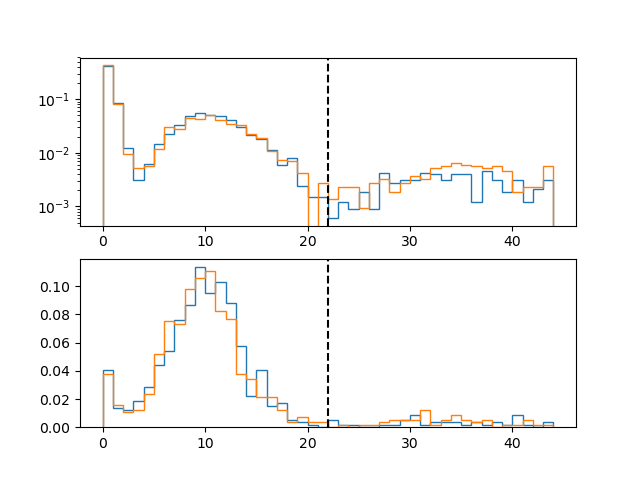

In [96]:
fig, ax = plt.subplots(2)

ax[0].hist(s1_nocut, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[0].hist(s1_nocut_ss, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[0].axvline(x=cuts[1][0], color='k', linestyle='--')
ax[0].set_yscale('log', nonposy='clip')
ax[1].hist(s1_cut, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[1].hist(s1_cut_ss, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')

#ax[1].set_yscale('log', nonposy='clip')
ax[1].axvline(x=cuts[1][0], color='k', linestyle='--')

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 's1_readout_ss-nonss_comp.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

s1_sig = np.mean(s1_cut)
s1_bg = np.mean(s1_nocut)

In [51]:
itr_cuts

{0: {0: [[146], [4]], 1: [[92], [4]]},
 1: {0: [[151], [4]], 1: [[95], [4]]},
 2: {0: [[156], [4]], 1: [[96], [4]]},
 3: {0: [[158], [4]], 1: [[96], [5]]},
 4: {0: [[151], [4]], 1: [[91], [5]]},
 5: {0: [[154], [4]], 1: [[94], [5]]},
 6: {0: [[153], [4]], 1: [[94], [5]]},
 7: {0: [[146], [5]], 1: [[89], [5]]},
 8: {0: [[150], [4]], 1: [[92], [5]]},
 9: {0: [[151], [5]], 1: [[96], [6]]}}

In [50]:
itr_cuts = {}
for itr in q.experiments[0]['iterations'].keys():
    results = q.generate_thresholds(itr=itr)
    itr_cuts[itr] = {
        0: q.get_thresholds()[0],
        1: q.get_thresholds()[1]
    }

On entry to DGESDD parameter number 5 had an illegal value
There may be some issue with your guess: `[  1.33200123e-18   0.00000000e+00   0.00000000e+00]`
On entry to DGESDD parameter number 5 had an illegal value
There may be some issue with your guess: `[  1.33200123e-18   0.00000000e+00   0.00000000e+00]`
On entry to DGESDD parameter number 5 had an illegal value
There may be some issue with your guess: `[  1.33200123e-18   0.00000000e+00   0.00000000e+00]`
On entry to DGESDD parameter number 5 had an illegal value
There may be some issue with your guess: `[  1.33200123e-18   0.00000000e+00   0.00000000e+00]`
On entry to DGESDD parameter number 5 had an illegal value
There may be some issue with your guess: `[  1.33200123e-18   0.00000000e+00   0.00000000e+00]`
On entry to DGESDD parameter number 5 had an illegal value
There may be some issue with your guess: `[  1.33200123e-18   0.00000000e+00   0.00000000e+00]`
On entry to DGESDD parameter number 5 had an illegal value
There may b

In [93]:
def G(x, mu, s):
    return np.exp(-(x-mu)**2 / (2*s**2))/np.sqrt(2*np.pi*s**2)

def S(x, muD, sD, muB, sB, a, p1, p2):
    return (1-p1-p2)*G(x, muD, sD) + p1*G(x, muB+muD, np.sqrt(sB**2+sD**2)) + p2*G(x, 2*muB+muD, np.sqrt(2*sB**2+sD**2))

def SP(x, muD, muB, a, p1, p2):
    return (1-p1-p2)*poisson.pmf(x, muD) + p1*poisson.pmf(x, muB+muD) + p2*poisson.pmf(x, 2*muB+muD)

<IPython.core.display.Javascript object>


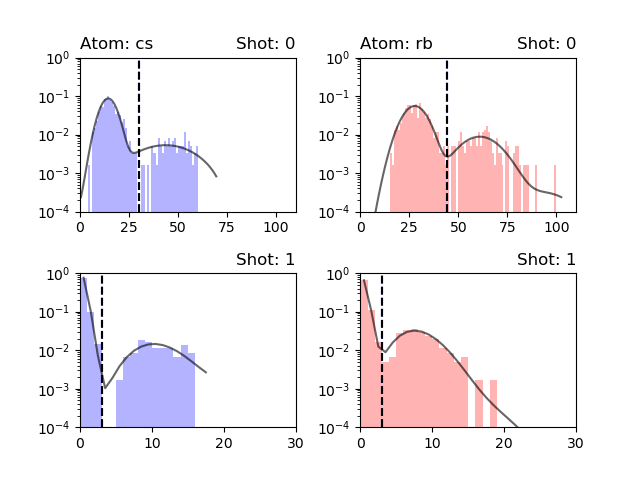

[  0.1334978   10.12695428   0.           0.11605815   0.01260286]
[  1.66179776e-01   7.37875410e+00   0.00000000e+00   2.21076602e-01
   3.79638703e-03]


In [157]:
shift = 0
fmt_map = ['b', 'r']
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for s in range(2):
    for r in range(2):        
        ax[s][r].fill_between(
            results[r][s]['hist_x']+shift,
            results[r][s]['hist_y'],
            facecolor=fmt_map[r],
            step='post',
            alpha=0.3
        )
        xs = np.arange(max(results[r][s]['hist_x'])+1)

        for i, xc in enumerate(results[r][s]['cuts']):
            if xc > 0:
                ax[s][r].axvline(x=xc, color='b', linestyle='--')
            ax[s][r].axvline(x=cuts[r][s][i], color='k', linestyle='--')
        
        if results[r][s]['fit_params'].shape[0]:
            if s:
                p1_g, muD_g, muB_g = results[r][s]['fit_params']
                muB_g -= muD_g
                guess =  [muD_g, muB_g, 0, p1_g, 0.02]
                popt, pcov = opt.curve_fit(
                    SP,
                    results[r][s]['hist_x']+shift,
                    results[r][s]['hist_y'],
                    p0=guess
                )
                ax[s][r].plot(xs+0.5, SP(xs, *popt), 'k', alpha=0.6)
                ax[s][r].set_xlim(0, 30)
                print(popt)
            else:
                p1_g, muD_g, muB_g = results[r][s]['fit_params']
                muB_g -= muD_g
                guess =  [muD_g, np.sqrt(muD_g), muB_g, np.sqrt(muB_g), 0, p1_g, 0.02]
                popt, pcov = opt.curve_fit(
                    S,
                    results[r][s]['hist_x']+shift,
                    results[r][s]['hist_y'],
                    p0=guess
                )
                ax[s][r].plot(xs+0.5, S(xs, *popt), 'k', alpha=0.6)
                ax[s][r].set_xlim(0, 110)

        if s >= 0:
            ax[s][r].set_yscale('log', nonposy='clip')
            ax[s][r].set_ylim(1e-4, 1e0)
        if s == 0:
            ax[s][r].set_title('Atom: {}'.format(roi_map[r]), loc='left')
        ax[s][r].set_title('Shot: {}'.format(s), loc='right')
# print results[s]['fit_params']
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/2
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/results[s]['fit_params'][2]

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'readout_hist_grid_2s.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

<IPython.core.display.Javascript object>


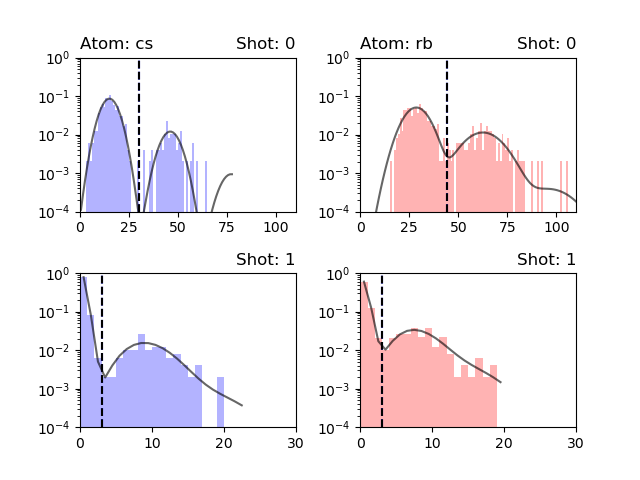

[  1.06085183e-01   8.84124579e+00   0.00000000e+00   1.15690071e-01
   6.72084558e-03]
[ 0.21002542  7.18407114  0.          0.22660799  0.02915715]


In [158]:
shift = 0
fmt_map = ['b', 'r']
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for s in range(2):
    for r in range(2):
        raw_data = q.experiments[0]['iterations'][1]['signal_data'][:,s,r,0]
        xs = np.arange(max(raw_data)+1)
        ys, xs = np.histogram(raw_data, xs, density=True)
        xs = xs[:-1]
        ax[s][r].fill_between(
            xs+shift,
            ys,
            facecolor=fmt_map[r],
            step='post',
            alpha=0.3
        )
        

        for i, xc in enumerate(results[r][s]['cuts']):
            if xc > 0:
                ax[s][r].axvline(x=xc, color='b', linestyle='--')
            ax[s][r].axvline(x=cuts[r][s][i], color='k', linestyle='--')
        
        if results[r][s]['fit_params'].shape[0]:
            if s:
                p1_g, muD_g, muB_g = results[r][s]['fit_params']
                muB_g -= muD_g
                guess =  [muD_g, muB_g, 0, p1_g, 0.02]
                popt, pcov = opt.curve_fit(
                    SP,
                    xs+shift,
                    ys,
                    p0=guess
                )
                ax[s][r].plot(xs+0.5, SP(xs, *popt), 'k', alpha=0.6)
                ax[s][r].set_xlim(0, 30)
                print(popt)
            else:
                p1_g, muD_g, muB_g = results[r][s]['fit_params']
                muB_g -= muD_g
                guess =  [muD_g, np.sqrt(muD_g), muB_g, np.sqrt(muB_g), 0, p1_g, 0.02]
                popt, pcov = opt.curve_fit(
                    S,
                    xs+shift,
                    ys,
                    p0=guess
                )
                ax[s][r].plot(xs+0.5, S(xs, *popt), 'k', alpha=0.6)
                ax[s][r].set_xlim(0, 110)

        if s >= 0:
            ax[s][r].set_yscale('log', nonposy='clip')
            ax[s][r].set_ylim(1e-4, 1e0)
        if s == 0:
            ax[s][r].set_title('Atom: {}'.format(roi_map[r]), loc='left')
        ax[s][r].set_title('Shot: {}'.format(s), loc='right')
# print results[s]['fit_params']
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/2
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/results[s]['fit_params'][2]

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'readout_hist_grid_2s_ssro.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

In [53]:
r=0
fig, ax = plt.subplots(figsize=(15,0.5))
qd = q.experiments[0]['iterations'][0]['quantized_data']
dps = 100
ax.fill_between(np.arange(dps), qd[:dps,1,0], step='post', facecolor="blue", alpha=0.8)
ax.fill_between(np.arange(dps), qd[:dps,0,0], step='post', facecolor="blue", alpha=0.4)
#ax.fill_between(np.arange(dps), qd[:dps,0,0], step='post', facecolor="blue")
#ax.fill_between(np.arange(dps), qd[:dps,0,0], where= step='post', facecolor="blue")
ax.fill_between(np.arange(dps), 1+qd[:dps,1,1], 1, step='post', facecolor="red", alpha=0.8)
ax.fill_between(np.arange(dps), 1+qd[:dps,0,1], 1, step='post', facecolor="red", alpha=0.4)

fn = os.path.join(dp, q.experiments[0]['source_path'], 'readout_load-ret_ts.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

FigureCanvasNbAgg()

In [54]:
np.correlate(qd[:dps,0,1], qd[:dps,0,1], mode="same")

array([  0.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
         1.,   2.,   3.,   2.,   2.,   2.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   2.,   2.,   2.,   0.,   0.,   0.,   0.,
         0.,   0.,   1.,   1.,   1.,   2.,   2.,   1.,   0.,   0.,   0.,
         0.,   0.,   1.,   1.,   3.,   4.,  10.,   4.,   3.,   1.,   1.,
         0.,   0.,   0.,   0.,   0.,   1.,   2.,   2.,   1.,   1.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   2.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   2.,   2.,   3.,
         2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
         1.])

In [13]:
q.experiments[0]['iterations'][0]['variables']

{u'CS_HF_shutter_delay_ms': 1.3999999999999999,
 u'CS_HF_shutter_time_ms': 1.2,
 u'Iq': -1.5,
 u'Ix': 0.24073531652999999,
 u'Ix_expt': 0.26546363000000001,
 u'Ix_op': 0.23363186,
 u'Ix_pgc': 0.17661790347299999,
 u'Ix_read': 0.46609574383800001,
 u'Ix_read_mz': 0.00055555555555599997,
 u'Iy': -0.17841671972699999,
 u'Iy_expt': -1.96848288,
 u'Iy_op': 0.044093960000000001,
 u'Iy_pgc': -0.074885315563999993,
 u'Iy_read': 0.45207059999999999,
 u'Iy_read_mz': -0.25999999999999995,
 u'Iz': -0.27452035548600001,
 u'Iz_expt': 0.40000000000000002,
 u'Iz_op': 0.40000000000000002,
 u'Iz_pgc': 0.076201182101300002,
 u'Iz_read': -0.103222020001,
 u'Iz_read_mz': -0.137166666667,
 u'MXY_shutter_delay_ms': 1.714,
 u'MXY_shutter_time_ms': 0.40000000000000002,
 u'MZ2_shutter_delay_ms': 1.3999999999999999,
 u'MZ2_shutter_time_ms': 0,
 u'M_shutter_delay_ms': 1.3799999999999999,
 u'M_shutter_time_ms': 1.0,
 u'OP_shutter_delay_ms': 1.6299999999999999,
 u'OP_shutter_time_ms': 1.2,
 u'RB_HF_shutter_delay_ms